In [1]:
import sys
from pathlib import Path
import subprocess
import os
import gc
from glob import glob

import numpy as np
import pandas as pd
import polars as pl
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

ROOT = '/kaggle/input/home-credit-credit-risk-model-stability'

from sklearn.model_selection import TimeSeriesSplit, GroupKFold, StratifiedGroupKFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer

In [2]:
class Pipeline:

    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))
        return df

    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))  #!!?
                df = df.with_columns(pl.col(col).dt.total_days()) # t - t-1
        df = df.drop("date_decision", "MONTH")
        return df

    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()
                if isnull > 0.7:
                    df = df.drop(col)
        
        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()
                if (freq == 1) | (freq > 200):
                    df = df.drop(col)
        
        return df


class Aggregator:
    #Please add or subtract features yourself, be aware that too many features will take up too much space.
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        return expr_max +expr_last+expr_mean
    
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        return  expr_max +expr_last+expr_mean
    
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        #expr_count = [pl.count(col).alias(f"count_{col}") for col in cols]
        return  expr_max +expr_last#+expr_count
    
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        return  expr_max +expr_last
    
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols] 
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        return  expr_max +expr_last
    
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    if depth in [1,2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df)) 
    return df

def read_files(regex_path, depth=None):
    chunks = []
    
    for path in glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)
        if depth in [1, 2]:
            df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
        chunks.append(df)
    
    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])
    return df

def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
    df_base = df_base.pipe(Pipeline.handle_dates)
    return df_base

def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    return df_data, cat_cols

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            continue
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
ROOT            = Path("/kaggle/input/home-credit-credit-risk-model-stability")

TRAIN_DIR       = ROOT / "parquet_files" / "train"
TEST_DIR        = ROOT / "parquet_files" / "test"

In [4]:
data_store = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
        read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
        read_file(TRAIN_DIR / "train_applprev_2.parquet", 2),
        read_file(TRAIN_DIR / "train_person_2.parquet", 2)
    ]
}

In [5]:
df_train = feature_eng(**data_store)
print("train data shape:\t", df_train.shape)
del data_store
gc.collect()
df_train = df_train.pipe(Pipeline.filter_cols)
df_train, cat_cols = to_pandas(df_train)
df_train = reduce_mem_usage(df_train)
print("train data shape:\t", df_train.shape)
nums=df_train.select_dtypes(exclude='category').columns
from itertools import combinations, permutations
#df_train=df_train[nums]
nans_df = df_train[nums].isna()
nans_groups={}
for col in nums:
    cur_group = nans_df[col].sum()
    try:
        nans_groups[cur_group].append(col)
    except:
        nans_groups[cur_group]=[col]
del nans_df; x=gc.collect()

def reduce_group(grps):
    use = []
    for g in grps:
        mx = 0; vx = g[0]
        for gg in g:
            n = df_train[gg].nunique()
            if n>mx:
                mx = n
                vx = gg
            #print(str(gg)+'-'+str(n),', ',end='')
        use.append(vx)
        #print()
    print('Use these',use)
    return use

def group_columns_by_correlation(matrix, threshold=0.8):
    # 计算列之间的相关性
    correlation_matrix = matrix.corr()

    # 分组列
    groups = []
    remaining_cols = list(matrix.columns)
    while remaining_cols:
        col = remaining_cols.pop(0)
        group = [col]
        correlated_cols = [col]
        for c in remaining_cols:
            if correlation_matrix.loc[col, c] >= threshold:
                group.append(c)
                correlated_cols.append(c)
        groups.append(group)
        remaining_cols = [c for c in remaining_cols if c not in correlated_cols]
    
    return groups

uses=[]
for k,v in nans_groups.items():
    if len(v)>1:
            Vs = nans_groups[k]
            #cross_features=list(combinations(Vs, 2))
            #make_corr(Vs)
            grps= group_columns_by_correlation(df_train[Vs], threshold=0.8)
            use=reduce_group(grps)
            uses=uses+use
            #make_corr(use)
    else:
        uses=uses+v
    print('####### NAN count =',k)
print(uses)
print(len(uses))
uses=uses+list(df_train.select_dtypes(include='category').columns)
print(len(uses))
df_train=df_train[uses]

train data shape:	 (1526659, 861)
Memory usage of dataframe is 4322.75 MB
Memory usage after optimization is: 1528.81 MB
Decreased by 64.6%
train data shape:	 (1526659, 472)
Use these ['case_id', 'WEEK_NUM', 'target', 'month_decision', 'weekday_decision', 'credamount_770A', 'applicationcnt_361L', 'applications30d_658L', 'applicationscnt_1086L', 'applicationscnt_464L', 'applicationscnt_867L', 'clientscnt_1022L', 'clientscnt_100L', 'clientscnt_1071L', 'clientscnt_1130L', 'clientscnt_157L', 'clientscnt_257L', 'clientscnt_304L', 'clientscnt_360L', 'clientscnt_493L', 'clientscnt_533L', 'clientscnt_887L', 'clientscnt_946L', 'deferredmnthsnum_166L', 'disbursedcredamount_1113A', 'downpmt_116A', 'homephncnt_628L', 'isbidproduct_1095L', 'mobilephncnt_593L', 'numactivecreds_622L', 'numactivecredschannel_414L', 'numactiverelcontr_750L', 'numcontrs3months_479L', 'numnotactivated_1143L', 'numpmtchanneldd_318L', 'numrejects9m_859L', 'sellerplacecnt_915L', 'max_mainoccupationinc_384A', 'max_birth_259D

In [6]:
sample = pd.read_csv("/kaggle/input/home-credit-credit-risk-model-stability/sample_submission.csv")
device='gpu'
#n_samples=200000
n_est=6000
DRY_RUN = True if sample.shape[0] == 10 else False   
if DRY_RUN:
    device='cpu'
    df_train = df_train.iloc[:50000]
    #n_samples=10000
    n_est=600
print(device)

cpu


In [7]:
data_store = {
    "df_base": read_file(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        read_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1),
        read_file(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR / "test_other_1.parquet", 1),
        read_file(TEST_DIR / "test_person_1.parquet", 1),
        read_file(TEST_DIR / "test_deposit_1.parquet", 1),
        read_file(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
        read_files(TEST_DIR / "test_credit_bureau_a_2_*.parquet", 2),
        read_file(TEST_DIR / "test_applprev_2.parquet", 2),
        read_file(TEST_DIR / "test_person_2.parquet", 2)
    ]
}

In [8]:
df_test = feature_eng(**data_store)
print("test data shape:\t", df_test.shape)
del data_store
gc.collect()
df_test = df_test.select([col for col in df_train.columns if col != "target"])
print("train data shape:\t", df_train.shape)
print("test data shape:\t", df_test.shape)

df_test, cat_cols = to_pandas(df_test, cat_cols)
df_test = reduce_mem_usage(df_test)

gc.collect()

test data shape:	 (10, 860)
train data shape:	 (50000, 389)
test data shape:	 (10, 388)
Memory usage of dataframe is 0.04 MB
Memory usage after optimization is: 0.02 MB
Decreased by 40.3%


0

### Feature Selection

In [9]:
y = df_train["target"]
weeks = df_train["WEEK_NUM"]
df_train= df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
cv = StratifiedGroupKFold(n_splits=5, shuffle=False)


In [10]:
df_train[cat_cols] = df_train[cat_cols].astype(str)
df_test[cat_cols] = df_test[cat_cols].astype(str)

In [11]:
from catboost import CatBoostClassifier, Pool

fitted_models = []
cv_scores = []


for idx_train, idx_valid in cv.split(df_train, y, groups=weeks):#
    X_train, y_train = df_train.iloc[idx_train], y.iloc[idx_train]# 
    X_valid, y_valid = df_train.iloc[idx_valid], y.iloc[idx_valid]
    train_pool = Pool(X_train, y_train,cat_features=cat_cols)
    val_pool = Pool(X_valid, y_valid,cat_features=cat_cols)
    clf = CatBoostClassifier(
    eval_metric='AUC',
    task_type='GPU',
    learning_rate=0.04,
    iterations=n_est)
    clf.fit(train_pool, eval_set=val_pool,verbose=300)
    fitted_models.append(clf)
    y_pred_valid = clf.predict_proba(X_valid)[:,1]
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores.append(auc_score)
    
print("CV AUC scores: ", cv_scores)
print("Maximum CV AUC score: ", max(cv_scores))

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5595068	best: 0.5595068 (0)	total: 14s	remaining: 2h 19m 43s
300:	test: 0.7401768	best: 0.7401768 (300)	total: 57.5s	remaining: 57.2s
599:	test: 0.7402455	best: 0.7405439 (510)	total: 1m 40s	remaining: 0us
bestTest = 0.7405439019
bestIteration = 510
Shrink model to first 511 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5960909	best: 0.5960909 (0)	total: 159ms	remaining: 1m 35s
300:	test: 0.7373504	best: 0.7373887 (290)	total: 44s	remaining: 43.7s
599:	test: 0.7407407	best: 0.7407407 (599)	total: 1m 27s	remaining: 0us
bestTest = 0.7407406867
bestIteration = 599


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6031942	best: 0.6031942 (0)	total: 161ms	remaining: 1m 36s
300:	test: 0.7699055	best: 0.7700565 (295)	total: 44.3s	remaining: 44s
599:	test: 0.7745863	best: 0.7745863 (599)	total: 1m 27s	remaining: 0us
bestTest = 0.7745862603
bestIteration = 599


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5775366	best: 0.5775366 (0)	total: 162ms	remaining: 1m 36s
300:	test: 0.7290036	best: 0.7290036 (300)	total: 44.2s	remaining: 43.9s
599:	test: 0.7322472	best: 0.7328460 (585)	total: 1m 28s	remaining: 0us
bestTest = 0.732845962
bestIteration = 585
Shrink model to first 586 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6058731	best: 0.6058731 (0)	total: 157ms	remaining: 1m 33s
300:	test: 0.7299382	best: 0.7299382 (300)	total: 43.8s	remaining: 43.5s
599:	test: 0.7335791	best: 0.7338448 (580)	total: 1m 27s	remaining: 0us
bestTest = 0.7338448167
bestIteration = 580
Shrink model to first 581 iterations.
CV AUC scores:  [0.7405439317082587, 0.7407412705042311, 0.7745862447219343, 0.7328459473966721, 0.7338447948701171]
Maximum CV AUC score:  0.7745862447219343


In [12]:
class VotingModel(BaseEstimator, RegressorMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    def predict_proba(self, X):
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

model = VotingModel(fitted_models)

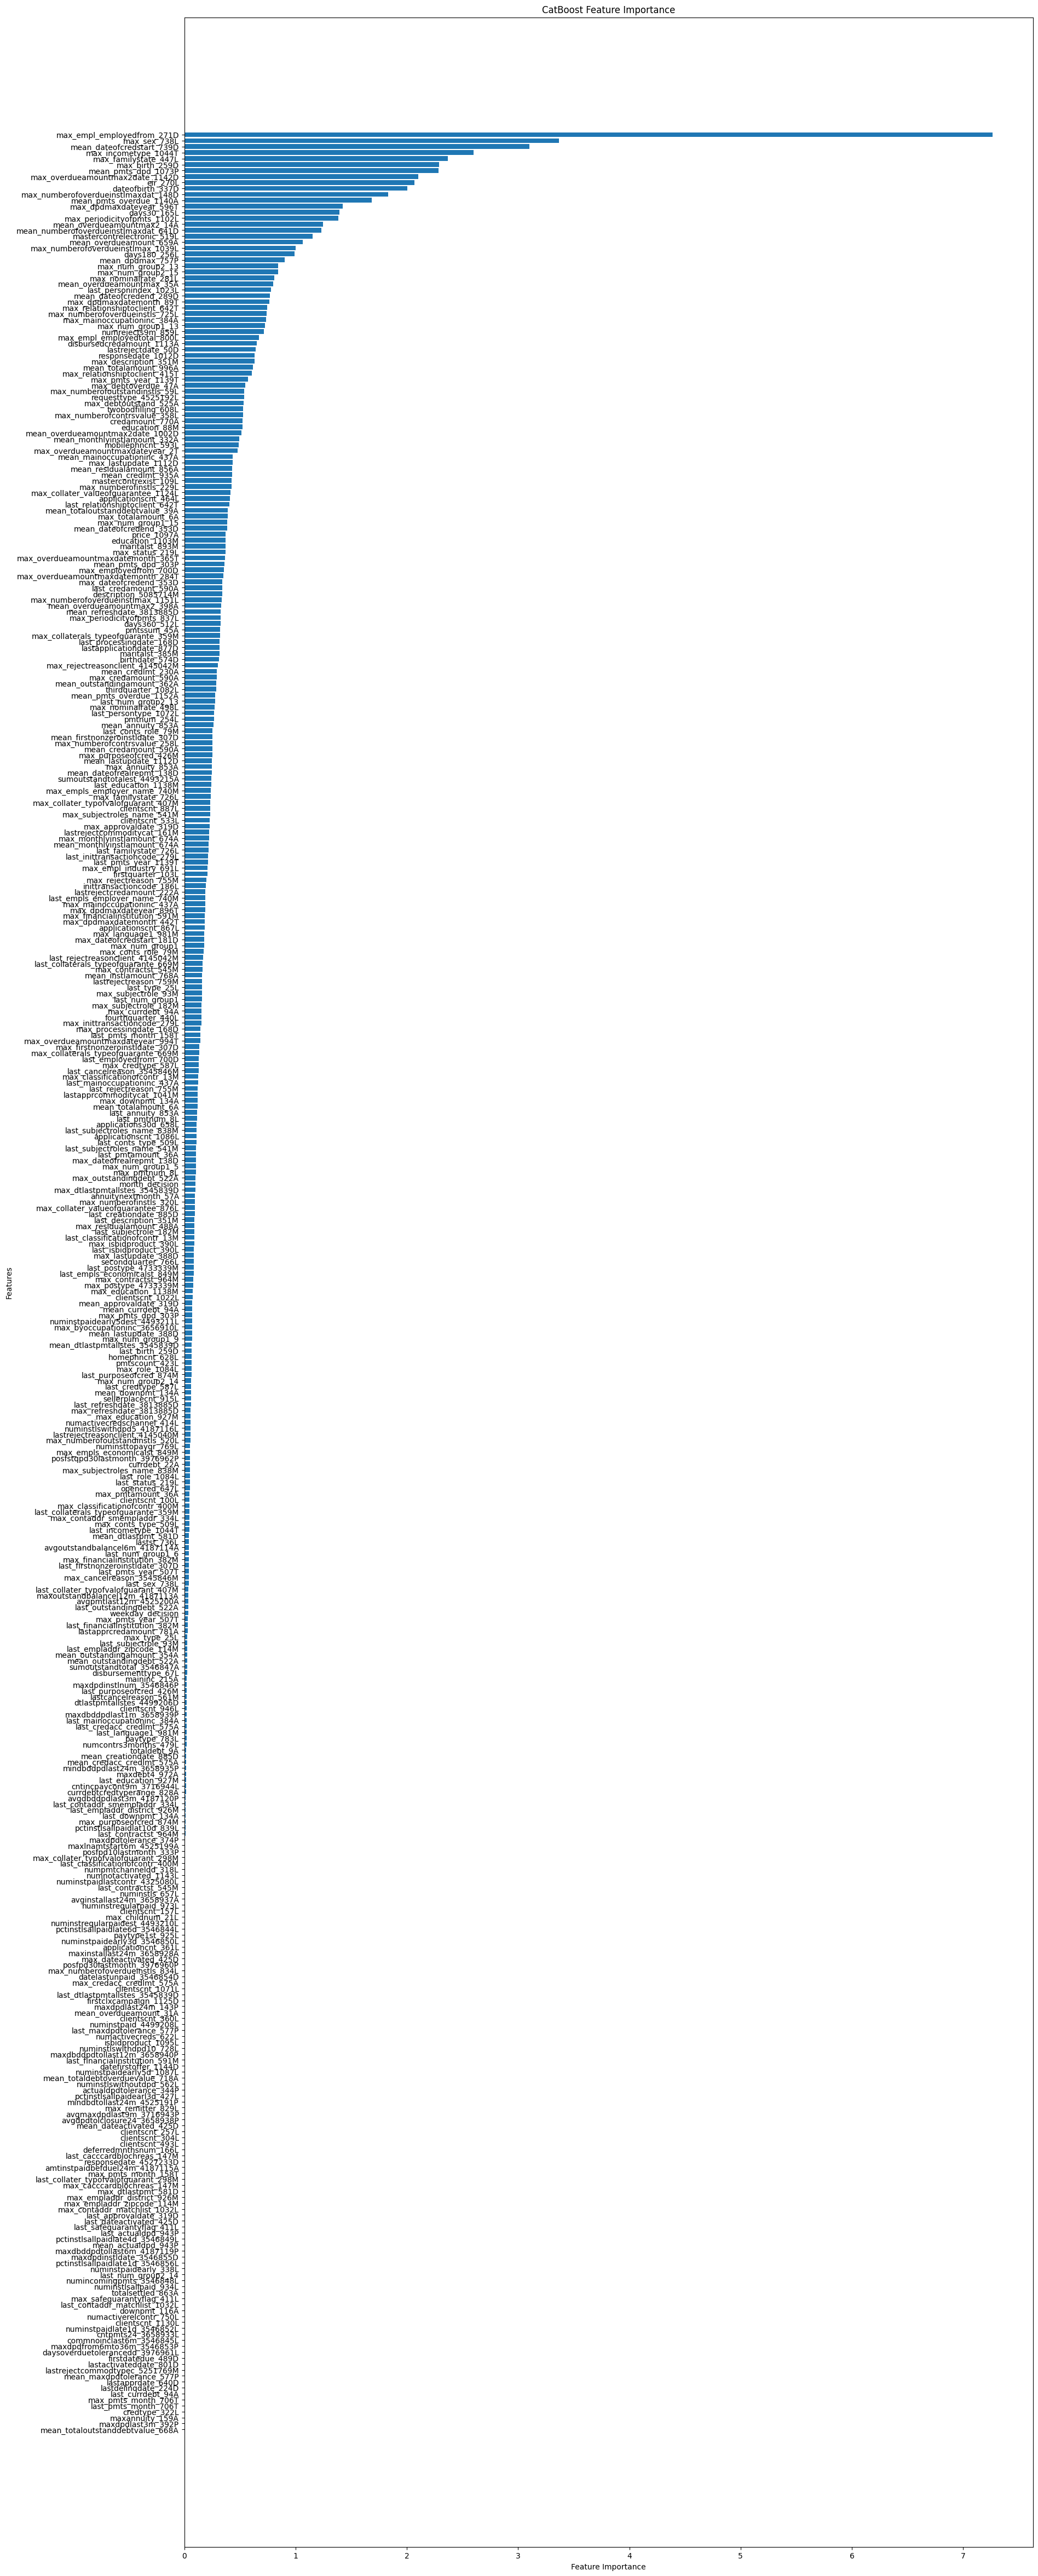

In [13]:

feature_importance =fitted_models[2].get_feature_importance(type='PredictionValuesChange')

# 获取特征名称
feature_names = X_train.columns

# 对特征重要性进行排序
sorted_idx = np.argsort(feature_importance)

# 绘制特征重要性图
plt.figure(figsize=(20, 60))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('CatBoost Feature Importance')
plt.show()

### Submission

In [14]:
df_test = df_test.drop(columns=["WEEK_NUM"])
df_test = df_test.set_index("case_id")


y_pred = pd.Series(model.predict_proba(df_test)[:, 1], index=df_test.index)
df_subm = pd.read_csv(ROOT / "sample_submission.csv")
df_subm = df_subm.set_index("case_id")

df_subm["score"] = y_pred
df_subm.to_csv("submission.csv")
df_subm

,score
case_id,
57543,0.022563
57549,0.033229
57551,0.022763
57552,0.060728
57569,0.057983
57630,0.031315
57631,0.056575
57632,0.054649
57633,0.035381
